# RESULTS Poker DVS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, online_accuracy
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

if torch.cuda.device_count() == 0:
    device = 'cpu'
else:
    device = 'cuda'
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

Tonic version installed -> 1.4.2
Number of GPU devices available: 0


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
trainloader = get_loader(trainset)
testloader = get_loader(testset)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 48
number of samples in the testing set: 20


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-06'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path = record_path, device = device)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, record_path = record_path, device = device)

initial_name_nohomeo = hots_nohomeo.name

../Records/networks/2022-06-06_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4].pkl
../Records/networks/2022-06-06_poker_homeohots_False_[8, 16]_[1000.0, 4000.0]_[2, 4].pkl


## Unsupervised clustering (Figure 4)

In [5]:
if not os.path.exists(hots.record_path):
    os.mkdir(hots.record_path)
    os.mkdir(hots.record_path+'networks/')
path = hots.record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, device = device)
path_nohomeo = hots.record_path+'networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, device = device)

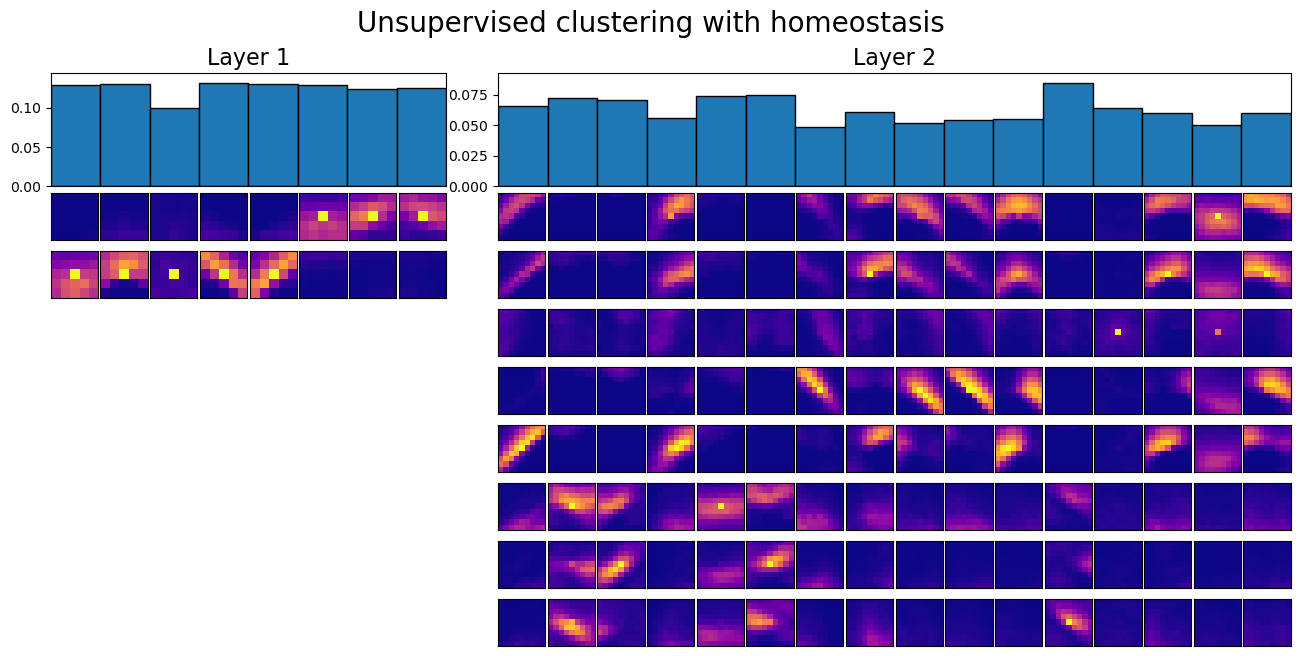

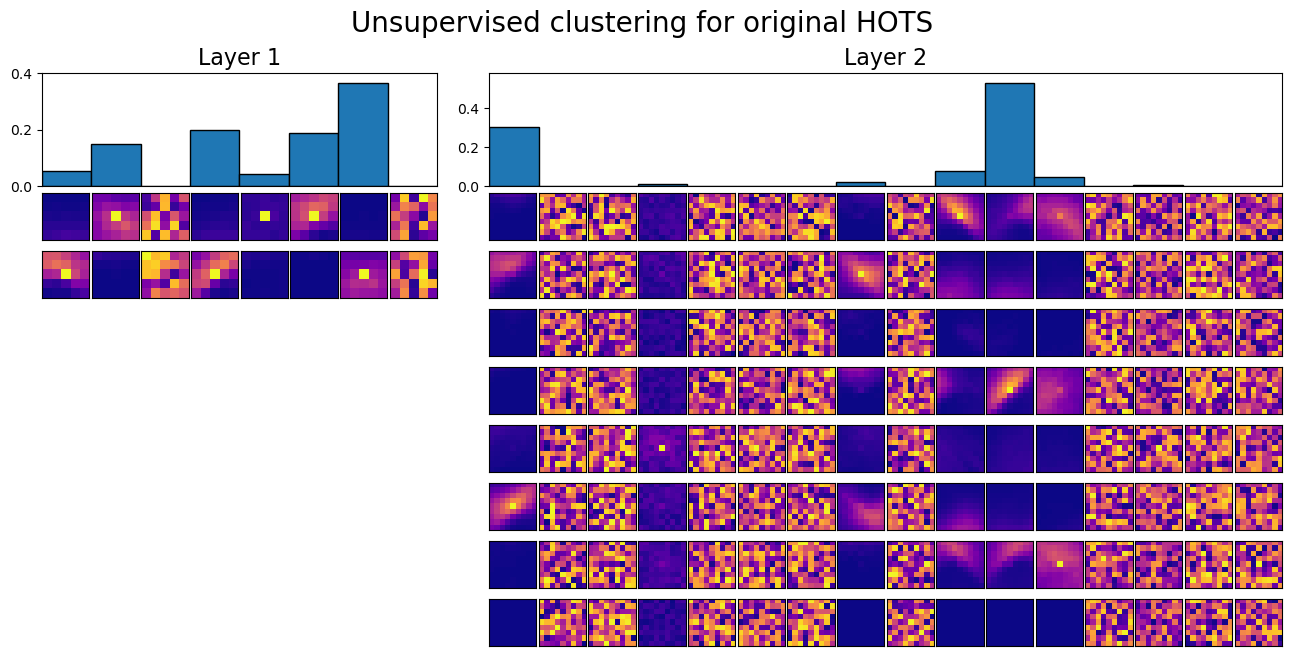

In [6]:
hots.plotlayers();
hots_nohomeo.plotlayers();

## Training of the classification layer

In [7]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 8e3

train_path = f'{hots.record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'{hots.record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'{hots.record_path}networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'{hots.record_path}LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device=device, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), device=device)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)

train_path_nohomeo = f'{hots.record_path}output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'{hots.record_path}output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, device=device, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 5-(a))

In [9]:
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1], device=device)
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1], device=device)

Number of chance decisions: 0
90th quantile for number of events: 4514.700000000001
Mean accuracy: 98.4%
Last accuracy: 100.0%
Highest probability accuracy: 100.0%


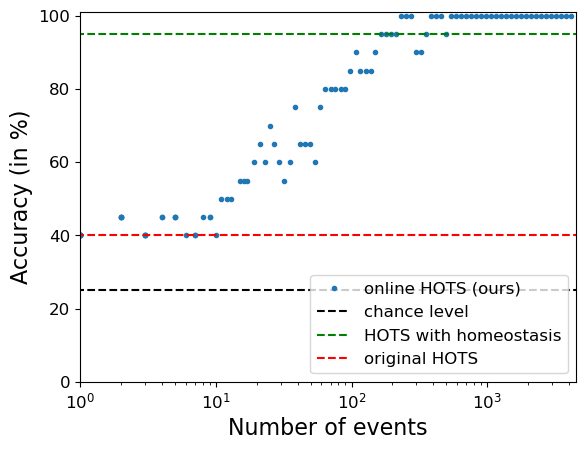

In [10]:
mlr_threshold = None
onlinac,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]
/mnt/pns/home/grimaldiav/Documents/hotsline/hots/utils.py:508: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Number of chance decisions: 0
90th quantile for number of events: 4514.700000000001
Mean accuracy: 100.0%
Last accuracy: 85.0%
Highest probability accuracy: 100.0%


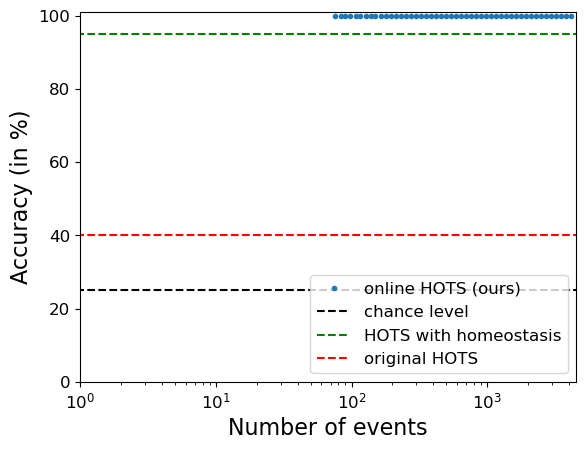

In [12]:
mlr_threshold = .9
onlinac_thres,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True, device=device)

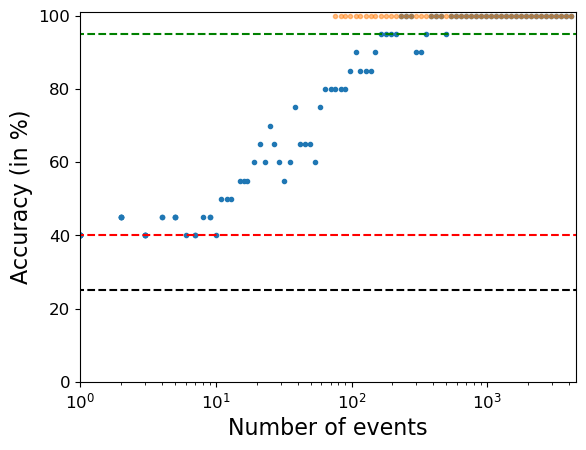

In [13]:
import matplotlib.pyplot as plt

event_90th = 4515
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.legend(fontsize=12, loc='lower right');
ax.set_ylabel('Accuracy (in %)', fontsize=16);
    #printfig(fig, figure_name)

## Robustness to spatial jitter (Figure 6-(a)-(up))

In [14]:
figname = 'spatial_jitter_poker.pdf'
fitting = True
fit_param = [[1, .7, 8, .1],[.9, 1/n_classes, 2, 10],[.6, 1/n_classes, 1, 10]]
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, fitting = fitting, fit_param = fit_param, device = device, verbose=True, figure_name = figname);

device -> cpu


  0%|                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

For spatial jitter equal to 0.0 - Trial number 0


TypeError: SpatialJitter.__init__() got an unexpected keyword argument 'variance_x'

## Robustness to temporal jitter (Figure 6-(a)-(down))

In [ ]:
figname = 'temporal_jitter_poker.pdf'
fitting = True
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, fitting = fitting, device = device, verbose=True, figure_name = figname);